In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:\\Users\\aksha\\OneDrive\\Documents\\mitb_sem2\\DSB\\group_project\\cosmetics\\cosmetics.csv",encoding="latin-1")
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"


In [3]:
def sizeclean(point):
    if type(point)==str:
        point=point.split(" ")[0]
        point=float(point)
    return point

In [4]:
df['size']=df['size'].apply(sizeclean)

In [5]:
# Convert the 'size' column to numeric, forcing errors to NaN
df['size'] = pd.to_numeric(df['size'], errors='coerce')

In [6]:
# Fill 'No type' for records with blank type value
df['type'] = df['type'].fillna('No type')
# Group by 'category' & 'subcategory' and fill NaN values with the mean of the group
df['size_cv'] = df.groupby(['category','subcategory'])['size'].transform(lambda x: x.fillna(x.mean()))
df['price_cv'] = df.groupby(['category','subcategory'])['price'].transform(lambda x: x.fillna(x.mean()))
df.isna().sum()

product_name       0
website            0
country            0
category           0
subcategory        0
title-href         0
price            317
brand              0
ingredients     6015
form               0
type               0
color           1989
size            3166
rating          2067
noofratings      459
size_cv            0
price_cv           0
dtype: int64

In [7]:
df.shape

(12615, 17)

Text(0.5, 1.0, 'Size_cv by Category')

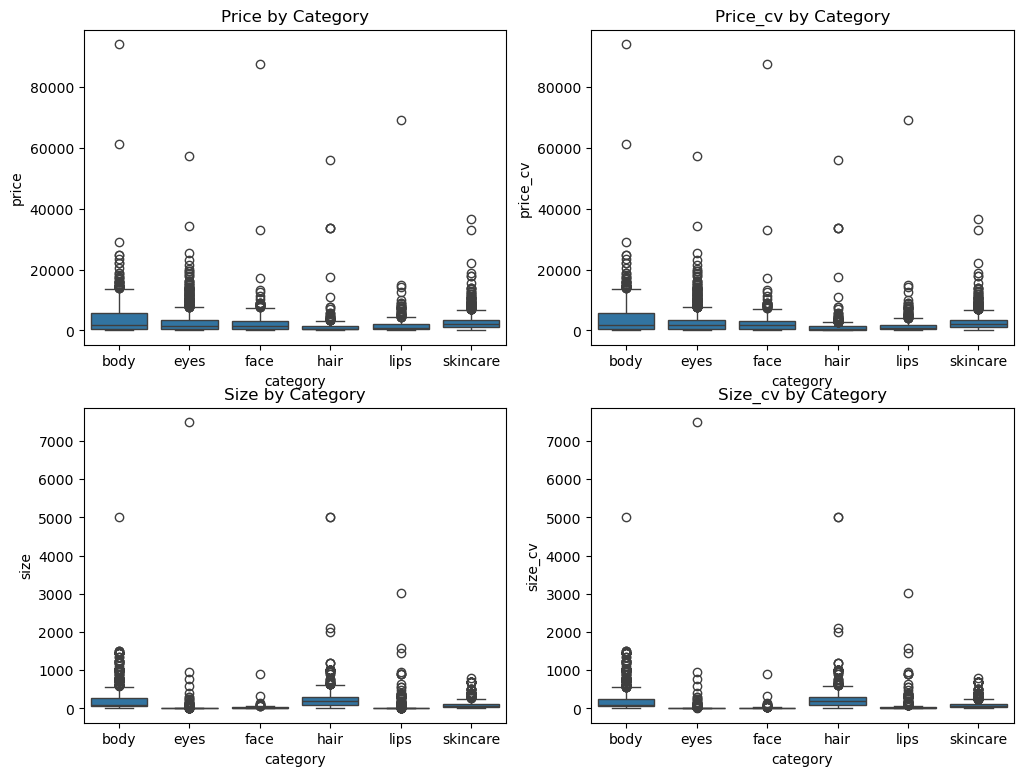

In [8]:
# check if the value after imputed with mean still have the same distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
sns.boxplot(ax=axes[0,0],x='category', y='price', data=df).set_title('Price by Category')
sns.boxplot(ax=axes[0,1],x='category', y='price_cv', data=df).set_title('Price_cv by Category')
sns.boxplot(ax=axes[1,0],x='category', y='size', data=df).set_title('Size by Category')
sns.boxplot(ax=axes[1,1],x='category', y='size_cv', data=df).set_title('Size_cv by Category')

**Option 1: Classify brand by price across all products**

In [9]:
# def classify_price(price):
#     if price > 10000:
#         return 'luxury brand'
#     elif price < 2860:
#         return 'budget'
#     elif 2860 <= price <= 10000:
#         return 'mid tier'
# df['brand_group'] = df['price_cv'].apply(classify_price)

# luxury_count = df[df['brand_group'] == 'luxury brand'].shape[0]
# budget_count = df[df['brand_group'] == 'budget'].shape[0]
# mid_tier_count = df[df['brand_group'] == 'mid tier'].shape[0]

# print(luxury_count,mid_tier_count,budget_count,luxury_count+mid_tier_count+budget_count )
# # print(df)

**Option 2: Classify brand/product class by price percentile in each category**

In [10]:
# Function to classify based on percentiles
def classify_price(x):
    if x <= 0.6:
        return 'Regular'
    elif x <= 0.95:
        return 'Premium'
    else:
        return 'Super Premium'

In [11]:
# The DataFrame df is grouped by the values in the ‘category’ column.
# The transform method applies a function to each group and returns a DataFrame with the same shape as the original.
# For each group(category), the rank(pct=True) function computes the percentile rank of each value in the ‘price’ column.
df['percentile'] = df.groupby('category')['price_cv'].transform(lambda x: x.rank(pct=True))
# Basis percentile value computed at category group level, the product is classified as one of the 3 class of products.
df['product_class'] = df['percentile'].apply(classify_price)

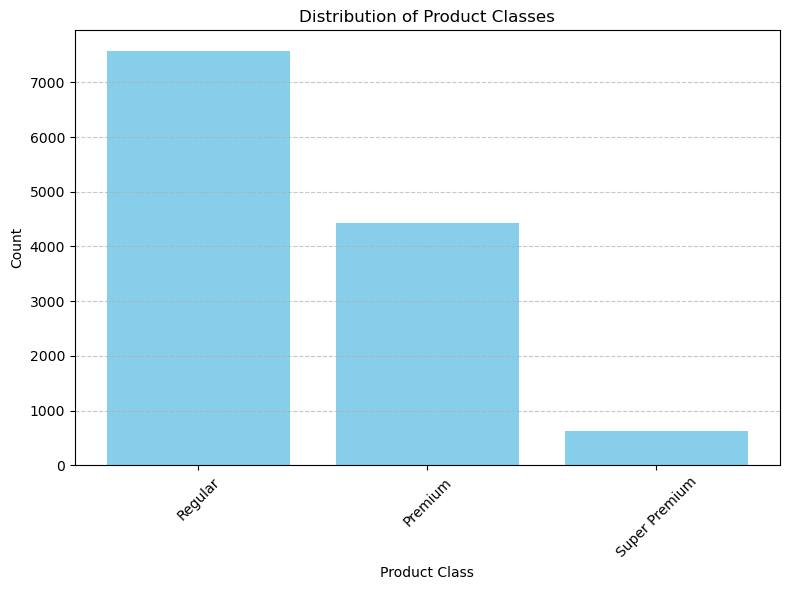

In [12]:
# Create a count plot (bar chart)
plt.figure(figsize=(8, 6))
plt.title('Distribution of Product Classes')
plt.xlabel('Product Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the counts
plt.bar(df['product_class'].value_counts().index, df['product_class'].value_counts().values, color='skyblue')

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# To remove the whitespaces front and back and convert to lower
df['brand'] = df['brand'].astype(str).str.strip().str.lower()

In [14]:
# Group by brand and product_class, and count occurrences
product_class_counts = df.groupby(['brand', 'product_class']).size().reset_index(name='count')

# Find the product class with the maximum count for each brand
max_product_class = product_class_counts.loc[product_class_counts.groupby('brand')['count'].idxmax()]

# Reset index for the final DataFrame
max_product_class = max_product_class.reset_index(drop=True)
max_product_class.rename(columns={'product_class':'brand_class'}, inplace=True)
print(max_product_class.shape, df.brand.nunique(), df.shape)
max_product_class.head(3)

(1646, 3) 1646 (12615, 19)


,brand,brand_class,count
0,100% pure,Premium,1
1,1000hour,Premium,1
2,18.21 man made,Regular,1


In [15]:
df = df.merge(max_product_class[['brand', 'brand_class']], on = 'brand', how = 'left')
df.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings,size_cv,price_cv,percentile,product_class,brand_class
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,carlton london,NaN,aerosol,No type,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,0.257926,Regular,Regular
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,charlene,NaN,aerosol,No type,Unit count type:,30.0,4.4,"4,031",30.0,149.0,0.030528,Regular,Regular
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,charlene,NaN,aerosol,No type,Unit count type:,30.0,4.4,"4,072",30.0,298.0,0.120352,Regular,Regular
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,denver,NaN,aerosol,No type,Long-Lasting Scent,60.0,4.2,61,60.0,245.0,0.087084,Regular,Regular
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,denver,NaN,aerosol,No type,Long-Lasting Scent,100.0,4.3,342,100.0,422.0,0.194912,Regular,Regular


**rating/noofratings Column Transform:**  if noofratings is blank & rating >10, then rating is noofratings. For the rest impute missing values using mean/median of the sub-category

In [16]:
df['rating'] = df['rating'].str.split(" ").str[0]
df['rating'] = df['rating'].str.replace(',', '')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
incorrect_ratings = df['rating'] > 10
df.loc[incorrect_ratings, 'noofratings'] = df.loc[incorrect_ratings, 'rating']
df.loc[incorrect_ratings, 'rating'] = 0

In [17]:
def ratingno(point):
    if point in ('Write A Review','No reviews','New to Amazon'):
        point = 0
    elif type(point)==str:
        point=point.split(" ")[0]
        point=point.replace(",","")
        point=float(point)
    return point
df['noofratings_cv']=df['noofratings'].apply(ratingno)

In [18]:
df['rating'] = df.groupby('subcategory')['rating'].transform(lambda x: x.fillna(x.mean()).mask((x == 0) | (x > 5), x.mean()))
df['rating'] = df['rating'].round(1)

In [19]:
print(df.shape)
df.isna().sum()

(12615, 21)


product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
dtype: int64

In [20]:
df.head(3)

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,...,color,size,rating,noofratings,size_cv,price_cv,percentile,product_class,brand_class,noofratings_cv
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,carlton london,NaN,aerosol,...,"Top Note: Orange Blossom, Blackberry | Heart N...",100.0,3.9,19,100.0,599.0,0.257926,Regular,Regular,19.0
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,031",30.0,149.0,0.030528,Regular,Regular,4031.0
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,charlene,NaN,aerosol,...,Unit count type:,30.0,4.4,"4,072",30.0,298.0,0.120352,Regular,Regular,4072.0


In [21]:
df.nunique()

product_name      11341
website               5
country               2
category              6
subcategory          36
title-href        12244
price              1975
brand              1646
ingredients        4839
form                 25
type                134
color              3357
size                526
rating               37
noofratings        2143
size_cv             549
price_cv           1989
percentile         3443
product_class         3
brand_class           3
noofratings_cv     1915
dtype: int64

In [22]:
# df.to_csv("C:\\Users\\aksha\\OneDrive\\Documents\\mitb_sem2\\DSB\\group_project\\cosmetics\\cosmetics_TP_final.csv",index=False)

### Convert to lower case before use all categorical
### Merge with loreal's dataset and use that categorical column instead of website, there too convert to categorical
### Write overall observations and per category whatever visible

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [24]:
df.columns

Index(['product_name', 'website', 'country', 'category', 'subcategory',
       'title-href', 'price', 'brand', 'ingredients', 'form', 'type', 'color',
       'size', 'rating', 'noofratings', 'size_cv', 'price_cv', 'percentile',
       'product_class', 'brand_class', 'noofratings_cv'],
      dtype='object')

In [25]:
# Importing GLobal Local Lorielle file
g_l = pd.read_csv("C:\\Users\\aksha\\OneDrive\\Documents\\mitb_sem2\\DSB\\group_project\\cosmetics\\Global_Local_Categorization_2.csv", encoding="latin-1",header=0)
g_l.head(3)

,brand,global/local
0,Da Bomb,global
1,Dionis,global
2,Dr Teal's,global


In [26]:
# Converting categorical columns to lowercase

df['product_class'] = df['product_class'].astype(str).str.strip().str.lower()
df['brand_class'] = df['brand_class'].astype(str).str.strip().str.lower()

g_l['brand'] = g_l['brand'].astype(str).str.strip().str.lower()
g_l['global/local'] = g_l['global/local'].astype(str).str.strip().str.lower()

In [27]:
g_l.head(3)

,brand,global/local
0,da bomb,global
1,dionis,global
2,dr teal's,global


In [28]:
g_l.nunique()

brand           266
global/local      3
dtype: int64

In [29]:
g_l['global/local'].unique()

array(['global', 'local', 'other'], dtype=object)

In [30]:
df.columns, df.shape

(Index(['product_name', 'website', 'country', 'category', 'subcategory',
        'title-href', 'price', 'brand', 'ingredients', 'form', 'type', 'color',
        'size', 'rating', 'noofratings', 'size_cv', 'price_cv', 'percentile',
        'product_class', 'brand_class', 'noofratings_cv'],
       dtype='object'),
 (12615, 21))

In [31]:
df = df.merge(g_l, on = 'brand', how = 'left')
del g_l
df.columns

Index(['product_name', 'website', 'country', 'category', 'subcategory',
       'title-href', 'price', 'brand', 'ingredients', 'form', 'type', 'color',
       'size', 'rating', 'noofratings', 'size_cv', 'price_cv', 'percentile',
       'product_class', 'brand_class', 'noofratings_cv', 'global/local'],
      dtype='object')

In [32]:
df.isna().sum()

product_name         0
website              0
country              0
category             0
subcategory          0
title-href           0
price              317
brand                0
ingredients       6015
form                 0
type                 0
color             1989
size              3166
rating             674
noofratings        405
size_cv              0
price_cv             0
percentile           0
product_class        0
brand_class          0
noofratings_cv     405
global/local      7729
dtype: int64

In [33]:
df[['global/local']] = df[['global/local']].fillna('other')

In [34]:
# # Function to perform linear regression category-wise
# def linear_regression_category_wise(df, category_col, dependent_var):
#     categories = df[category_col].unique()
#     results = {}

#     # Define the column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(), ['website', 'product_class', 'brand_class']),
#             ('num', SimpleImputer(strategy='median'), ['noofratings_cv', 'size_cv', 'rating'])
#         ])

#     # Create a pipeline that includes preprocessing and regression
#     model = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', LinearRegression())
#     ])

#     for category in categories:
#         df_category = df[df[category_col] == category]
#         X = df_category.drop(columns=[category_col, dependent_var])
#         y = df_category[dependent_var]

#         model.fit(X, y)

#         results[category] = {
#             'coefficients': model.named_steps['regressor'].coef_,
#             'intercept': model.named_steps['regressor'].intercept_,
#             'r_squared': model.score(X, y)
#         }

#     return results

# # Run the linear regression for each category and print the results
# results = linear_regression_category_wise(df, 'category', 'price_cv')

# for category, result in results.items():
#     print(f"Category: {category}")
#     print(f"  Coefficients: {result['coefficients']}")
#     print(f"  Intercept: {result['intercept']}")
#     print(f"  R-squared: {result['r_squared']}\n")

In [35]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Function to perform linear regression category-wise
def linear_regression_category_wise(df, category_col, dependent_var):
    categories = df[category_col].unique()
    results = {}

    # Define the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), ['global/local', 'product_class', 'brand_class']),
            ('num', SimpleImputer(strategy='median'), ['noofratings_cv', 'size_cv', 'rating'])
        ])

    # Create a pipeline that includes preprocessing and regression
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Fit the preprocessor to extract feature names
    preprocessor.fit(df.drop(columns=[category_col, dependent_var]))
    feature_names = preprocessor.get_feature_names_out()

    for category in categories:
        df_category = df[df[category_col] == category]
        X = df_category.drop(columns=[category_col, dependent_var])
        y = df_category[dependent_var]

        model.fit(X, y)

        results[category] = {
            'coefficients': model.named_steps['regressor'].coef_,
            'intercept': model.named_steps['regressor'].intercept_,
            'r_squared': model.score(X, y),
            'feature_names': feature_names
        }

    return results

# Calculating Ratings
results = linear_regression_category_wise(df, 'category', 'price_cv')

for category, result in results.items():
    print(f"Category: {category}")
    print(f"  Feature Names: {result['feature_names']}")
    print(f"  Coefficients: {result['coefficients']}")
    print(f"  Intercept: {result['intercept']}")
    print(f"  R-squared: {result['r_squared']}\n")


Category: body
  Feature Names: ['cat__global/local_global' 'cat__global/local_local'
 'cat__global/local_other' 'cat__product_class_premium'
 'cat__product_class_regular' 'cat__product_class_super premium'
 'cat__brand_class_premium' 'cat__brand_class_regular'
 'cat__brand_class_super premium' 'num__noofratings_cv' 'num__size_cv'
 'num__rating']
  Coefficients: [ 2.31500168e+02 -2.39525898e+02  8.02572993e+00 -9.74685863e+02
 -5.18554105e+03  6.16022692e+03 -1.59807729e+03 -2.80485070e+03
  4.40292799e+03 -3.85361686e-03 -4.64179868e-01  8.21317002e+01]
  Intercept: 8540.531511421063
  R-squared: 0.7104837273206248

Category: eyes
  Feature Names: ['cat__global/local_global' 'cat__global/local_local'
 'cat__global/local_other' 'cat__product_class_premium'
 'cat__product_class_regular' 'cat__product_class_super premium'
 'cat__brand_class_premium' 'cat__brand_class_regular'
 'cat__brand_class_super premium' 'num__noofratings_cv' 'num__size_cv'
 'num__rating']
  Coefficients: [ 2.116287

In [36]:
# import pandas as pd
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LinearRegression

# # Function to perform linear regression category-wise
# def linear_regression_category_wise(df, category_col, dependent_var):
#     categories = df[category_col].unique()
#     results = {}

#     # Define the column transformer
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('cat', OneHotEncoder(), ['global/local', 'product_class', 'brand_class']),
#             ('num', SimpleImputer(strategy='median'), ['noofratings_cv', 'size_cv'])
#         ])

#     # Create a pipeline that includes preprocessing and regression
#     model = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', LinearRegression())
#     ])

#     # Fit the preprocessor to extract feature names
#     preprocessor.fit(df.drop(columns=[category_col, dependent_var]))
#     feature_names = preprocessor.get_feature_names_out()

#     for category in categories:
#         df_category = df[df[category_col] == category]
#         X = df_category.drop(columns=[category_col, dependent_var])
#         y = df_category[dependent_var]

#         model.fit(X, y)

#         results[category] = {
#             'coefficients': model.named_steps['regressor'].coef_,
#             'intercept': model.named_steps['regressor'].intercept_,
#             'r_squared': model.score(X, y),
#             'feature_names': feature_names
#         }

#     return results

# # Calculating Ratings
# results = linear_regression_category_wise(df, 'category', 'price_cv')

# for category, result in results.items():
#     print(f"Category: {category}")
#     print(f"  Feature Names: {result['feature_names']}")
#     print(f"  Coefficients: {result['coefficients']}")
#     print(f"  Intercept: {result['intercept']}")
#     print(f"  R-squared: {result['r_squared']}\n")


Category: body
  Feature Names: ['cat__global/local_global' 'cat__global/local_local'
 'cat__global/local_other' 'cat__product_class_premium'
 'cat__product_class_regular' 'cat__product_class_super premium'
 'cat__brand_class_premium' 'cat__brand_class_regular'
 'cat__brand_class_super premium' 'num__noofratings_cv' 'num__size_cv']
  Coefficients: [ 2.34321538e+02 -2.37357259e+02  3.03572171e+00 -9.75712013e+02
 -5.18932483e+03  6.16503685e+03 -1.58878602e+03 -2.80496039e+03
  4.39374641e+03 -3.70317507e-03 -4.51120715e-01]
  Intercept: 8892.590896455527
  R-squared: 0.7104267605666749

Category: eyes
  Feature Names: ['cat__global/local_global' 'cat__global/local_local'
 'cat__global/local_other' 'cat__product_class_premium'
 'cat__product_class_regular' 'cat__product_class_super premium'
 'cat__brand_class_premium' 'cat__brand_class_regular'
 'cat__brand_class_super premium' 'num__noofratings_cv' 'num__size_cv']
  Coefficients: [ 2.13851722e+02 -3.20224918e+02  1.06373196e+02 -1.7952